In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('tables.csv')

In [3]:
A = []
for i in df.columns:
    if i[-2:] != "id":
        A += [i]
df = df[A]

In [4]:
df['duratoin_sec'] = df['duratoin_sec'].str.replace(',','.')
df.duratoin_sec = df.duratoin_sec.astype(float)

In [5]:
df.isna().sum()

task_rk                       0
source_system_cd              0
create_dttm                   0
finish_dttm                 753
wo_hit_rk                     0
wo_task_rk                    0
agent_login                   0
wo_employee_rk                0
finish_dttm:1                 0
duratoin_sec                  0
hit_rk                        0
hit_rk:1                      0
using_flg                 86649
employee_rk                   0
org_group_rk                  0
org_group_rk:1                0
org_management_rk             0
group_nm                      0
org_management_rk:1           0
management_nm                 0
hit_status_result_id:1        0
hit_status_result_desc        0
queue_desc                    2
agent_login:1                 0
horoscope                     0
dtype: int64

In [6]:
df.create_dttm = pd.to_datetime(df.create_dttm, format="%Y.%m.%d %H:%M:%S", errors = 'ignore')
df.finish_dttm = pd.to_datetime(df.finish_dttm, format="%Y.%m.%d %H:%M:%S", errors = 'ignore')
df['finish_dttm:1'] = pd.to_datetime(df['finish_dttm:1'], format="%Y.%m.%d %H:%M:%S", errors = 'ignore')

In [7]:
df["create_dttm"] = [d.date() for d in df["create_dttm"]]
df["finish_dttm:1"] = [d.date() for d in df["finish_dttm:1"]]

<Axes: >

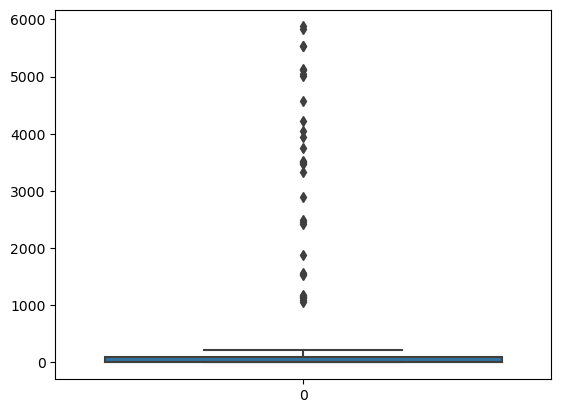

In [8]:
# выбросы
sns.boxplot(df['duratoin_sec'])

In [9]:
# меняем выбросы на среднее значение
df[df['duratoin_sec'] > 300].duratoin_sec = df[df['duratoin_sec'] != 0].duratoin_sec.mean()

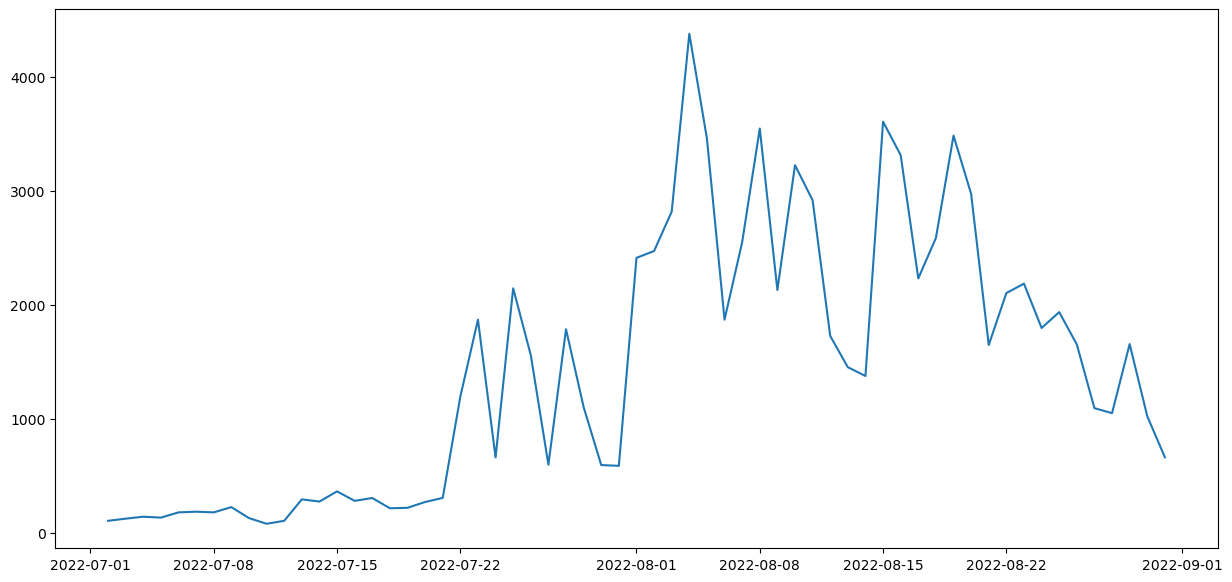

In [10]:
# строим Time series и делаем декомпозицию
series_1 = df[["create_dttm", 'duratoin_sec']].groupby(['create_dttm']).count()
series_1['create_dttm'] = pd.to_datetime(series_1.index, format="%Y.%m.%d %H:%M:%S", errors = 'ignore')

series_1 = series_1[series_1['create_dttm'] > '2022-07-01']

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(series_1.duratoin_sec)

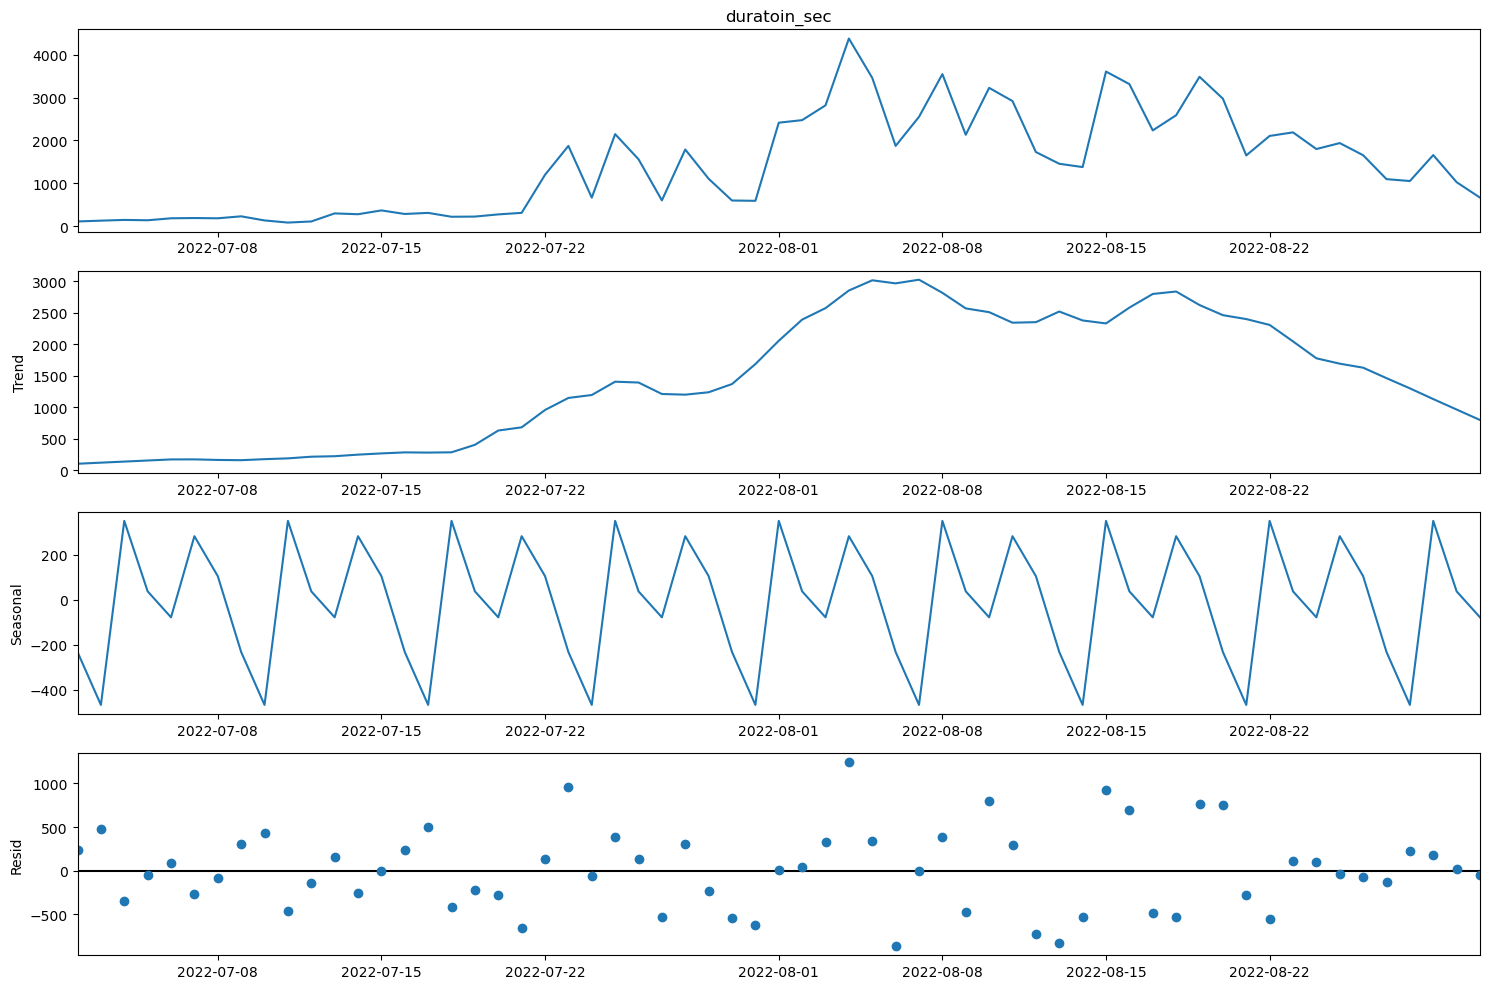

In [19]:
# по количеству звонков есть недельная сезонность, тренд возрастающий
from statsmodels.tsa.seasonal import seasonal_decompose
ts_dicomposition = seasonal_decompose(series_1.duratoin_sec, model='additive', period=7, extrapolate_trend=1)
fig =  ts_dicomposition.plot()
plt.rcParams['figure.figsize'] = [15.0,10.0]

In [12]:
# вычислим среднее время звонка и кол-во звонков по которым был "Дозвон"
df_1 = df[df.hit_status_result_desc.str.contains('Дозвон')]
for i in ['horoscope', 'hit_status_result_desc']:
    print(df_1[['duratoin_sec', i]].groupby([i]).mean())
    print(df_1[['duratoin_sec', i]].groupby([i]).count())

           duratoin_sec
horoscope              
Близнецы     108.072582
Весы         110.050564
Водолей      109.660142
Дева         116.902205
Козерог      112.094588
Лев          113.033495
Овен         110.167750
Рак          108.933560
Рыбы         109.453299
Скорпион     110.721280
Стрелец      108.276558
Телец        110.354443
           duratoin_sec
horoscope              
Близнецы           3091
Весы               2981
Водолей            2534
Дева              15523
Козерог            1249
Лев                 555
Овен               2093
Рак                3152
Рыбы               2034
Скорпион            836
Стрелец            1717
Телец              2818
                                        duratoin_sec
hit_status_result_desc                              
Дозвон, Некорректное задание по звонку     83.216538
Дозвон, Отказ                             112.487501
Дозвон, Отложить                          122.785708
Дозвон, Перезвонить                       112.119014
Дозвон, Ус

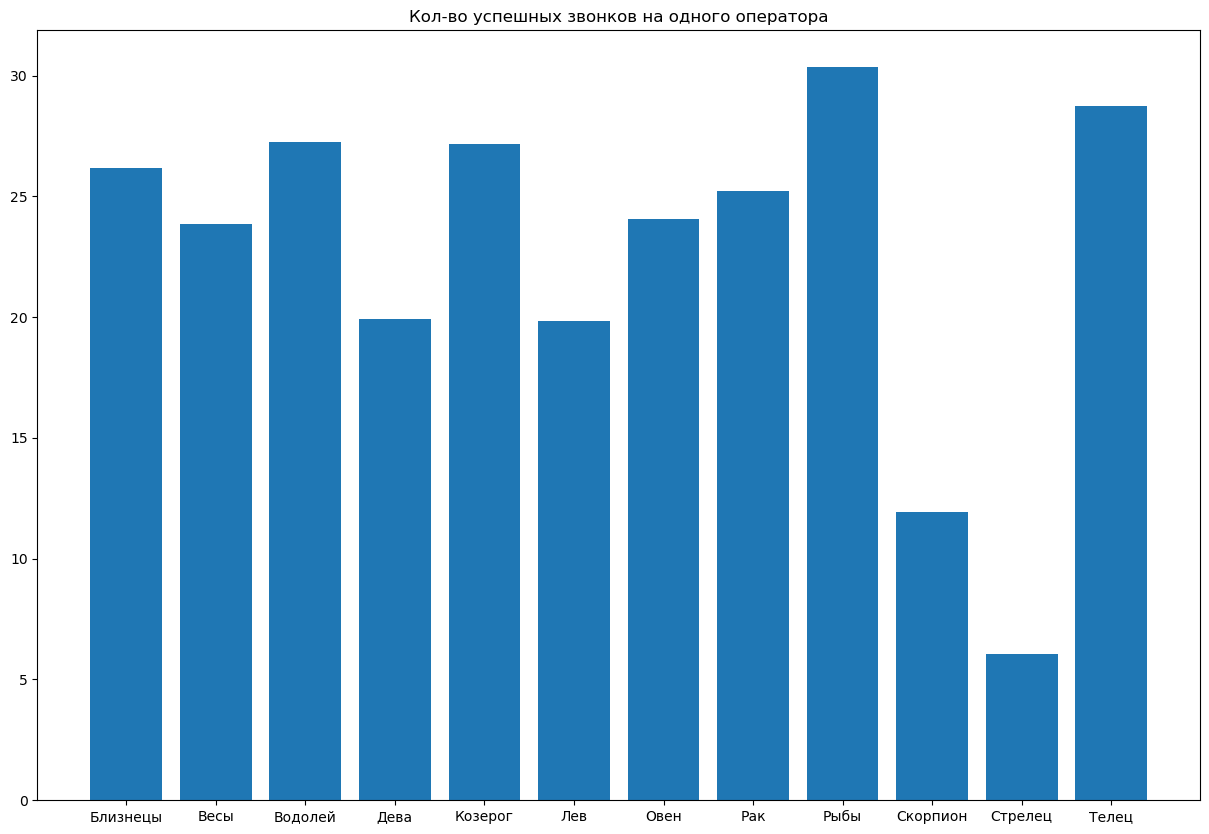

In [13]:
# Исходя из графика можем сделать вывод, что стрельцы оказались наименее эффективны. 
# Поробуем проверить теорию, что стрельцы также эффективны как и остальные сотрудники
A = df_1[['duratoin_sec', 'horoscope']].groupby(['horoscope']).count().duratoin_sec / df_1[['agent_login','horoscope']].groupby(['horoscope']).nunique().agent_login
fig, ax = plt.subplots()

x = A.index
y = A

ax.bar(x, y)

ax.set_title('Кол-во успешных звонков на одного оператора')

plt.show()

In [14]:
df_1[['duratoin_sec', 'horoscope']].groupby(['horoscope']).count().duratoin_sec 
/ df_1[['agent_login','horoscope']].groupby(['horoscope']).nunique().agent_login

horoscope
Близнецы    118
Весы        125
Водолей      93
Дева        779
Козерог      46
Лев          28
Овен         87
Рак         125
Рыбы         67
Скорпион     70
Стрелец     284
Телец        98
Name: agent_login, dtype: int64

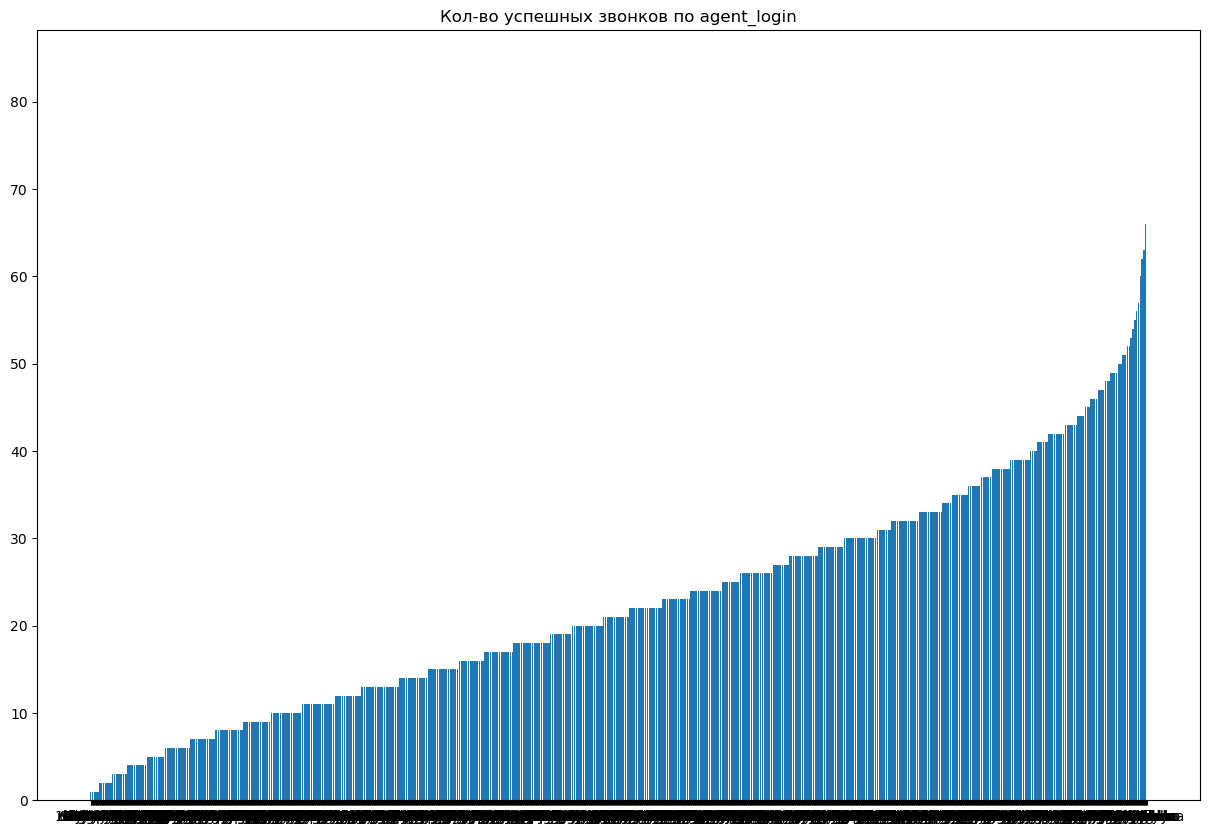

In [15]:
A = df_1[df_1['horoscope'] != 'Стрелец'][['agent_login', 'horoscope']].groupby('agent_login').count().horoscope.sort_values()

fig, ax = plt.subplots()

x = A.index
y = A

ax.bar(x, y)

ax.set_title('Кол-во успешных звонков по agent_login')

plt.show()

In [16]:
# тест показывает, что распределение близко к нормальному
from scipy import stats
A = df_1[df_1['horoscope'] != 'Стрелец'][['agent_login', 'horoscope']].groupby('agent_login').count().horoscope.sort_values()
res = stats.shapiro(A.values)
print(res.statistic)
B = df_1[df_1['horoscope'] == 'Стрелец'][['agent_login', 'horoscope']].groupby('agent_login').count().horoscope.sort_values()
res = stats.shapiro(B.values)
print(res.statistic)

0.9677906632423401
0.7200320959091187


In [17]:
# проверим теорию, что стрельцы так же продуктивны 
import scipy
stats.ttest_ind(A, B)

Ttest_indResult(statistic=20.910925293801874, pvalue=1.2315848593100608e-87)

In [18]:
# Гипотеза не подтвердилась, стрельцы оказались менее эффективны